In [1]:
# Basic data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots 
import seaborn as sns
from wordcloud import WordCloud

# Text preprocessing
import re
import ast
import unicodedata
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer


Data Collection

In [2]:
df = pd.read_csv('/Users/thoufeq/Cooking_Assistant/notebook/1_Recipe_csv.csv')
df.head(2)

,recipe_title,category,subcategory,description,ingredients,directions,num_ingredients,num_steps
0,Air Fryer Potato Slices with Dipping Sauce,Air Fryer Recipes,Air Fryer Recipes,"These air fryer potato slices, served with a b...","[""3/4 cup ketchup"", ""1/2 cup beer"", ""1 tablesp...","[""Combine ketchup, beer, Worcestershire sauce,...",9,5
1,Gochujang Pork Belly Bites,Air Fryer Recipes,Air Fryer Recipes,These gochujang pork belly bites are sweet and...,"[""1 pound pork belly"", ""1/4 cup gochujang"", ""2...","[""Preheat an air fryer to 400 degrees F (200 d...",5,4


INFO

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62126 entries, 0 to 62125
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   recipe_title     62126 non-null  object
 1   category         62126 non-null  object
 2   subcategory      62126 non-null  object
 3   description      62126 non-null  object
 4   ingredients      62126 non-null  object
 5   directions       62126 non-null  object
 6   num_ingredients  62126 non-null  int64 
 7   num_steps        62126 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 3.8+ MB


Descriptive Statistics

In [4]:
df.describe(include='all')


,recipe_title,category,subcategory,description,ingredients,directions,num_ingredients,num_steps
count,62126,62126,62126,62126,62126,62126,62126.000000,62126.000000
unique,24971,267,1032,25015,24971,25014,NaN,NaN
top,Blackened Chicken,Main Dishes,Meatloaf,Blackened chicken is quick and easy to make at...,"[""cooking spray""]","[""Gather all ingredients. Preheat the oven to ...",NaN,NaN
freq,26,3387,320,26,72,26,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,9.017448,4.661865
std,NaN,NaN,NaN,NaN,NaN,NaN,3.830323,2.310253
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,3.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,4.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,6.000000


Check Missing Values

In [5]:
df.isnull().sum()

recipe_title       0
category           0
subcategory        0
description        0
ingredients        0
directions         0
num_ingredients    0
num_steps          0
dtype: int64

Check Duplicates

In [6]:
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


Check Data Types & Parse JSON Columns¶

In [7]:
def parse_json_column(x):
    try:
        if isinstance(x, list):
            return x
        return ast.literal_eval(x)
    except:
        return []# Return empty list if parsing fails

# Apply to ingredients and directions
df['ingredients_list'] = df['ingredients'].apply(parse_json_column)
df['directions_list'] = df['directions'].apply(parse_json_column)

print(type(df['ingredients_list'][0]))
print(type(df['directions_list'][0]))

<class 'list'>
<class 'list'>


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62126 entries, 0 to 62125
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   recipe_title      62126 non-null  object
 1   category          62126 non-null  object
 2   subcategory       62126 non-null  object
 3   description       62126 non-null  object
 4   ingredients       62126 non-null  object
 5   directions        62126 non-null  object
 6   num_ingredients   62126 non-null  int64 
 7   num_steps         62126 non-null  int64 
 8   ingredients_list  62126 non-null  object
 9   directions_list   62126 non-null  object
dtypes: int64(2), object(8)
memory usage: 4.7+ MB


Data Cleaning & Preprocessing

In [9]:
# Columns to clean text
text_cols = ['recipe_title', 'description', 'ingredients', 'directions', 'category', 'subcategory']

for col in text_cols:
    # Fix encoding issues
    df[col] = df[col].str.replace('â€”', '—', regex=False)
    df[col] = df[col].str.replace('â€"', '"', regex=False)  # optional
    # Trim whitespace
    df[col] = df[col].str.strip()

# Handle empty JSON arrays
df['ingredients_list'] = df['ingredients_list'].apply(lambda x: x if isinstance(x, list) else [])
df['directions_list'] = df['directions_list'].apply(lambda x: x if isinstance(x, list) else [])

# Remove recipes with empty ingredients or directions
df = df[df['ingredients_list'].map(len) > 0]
df = df[df['directions_list'].map(len) > 0]

print(f"Remaining recipes after cleaning: {len(df)}")

Remaining recipes after cleaning: 62126


Univariate Analysis¶
Univariate Analysis: Numerical Features
We analyze the numerical features to understand recipe complexity and patterns:

num_ingredients: Number of ingredients per recipe.
num_steps: Number of steps in the recipe directions.
We visualize their distributions using histograms and boxplots, and examine summary statistics (mean, median, quartiles, min, max).

Insights:-

    Number of Ingredients:

        Median ≈ 9 ingredients.
        Most recipes use between 6 and 11 ingredients (IQR).
        Outliers exist beyond 18 ingredients, with a maximum of ~35.(this might not be a outlier but a very complex recipe)
        Insight: The majority of recipes are moderately complex, but some are unusually ingredient-heavy.

    Number of Steps:

        Median ≈ 4–5 steps.
        Most recipes have 3–6 steps (IQR), peaking around 4–6 steps in histograms.
        Outliers appear beyond 12 steps, with some recipes going up to ~25.(this might not be a outlier but a very complex recipe)
        Distribution is right-skewed, meaning long recipes are rare.
        Insight: Most recipes are relatively simple, but a few are very detailed or complex.

In [10]:
# Create numerical features
df['num_ingredients'] = df['ingredients_list'].apply(len)
df['num_steps'] = df['directions_list'].apply(len)

# Summary stats
print("Summary Statistics:")
print(df[['num_ingredients','num_steps']].describe())

Summary Statistics:
       num_ingredients     num_steps
count     62126.000000  62126.000000
mean          9.017448      4.661865
std           3.830323      2.310253
min           1.000000      1.000000
25%           6.000000      3.000000
50%           9.000000      4.000000
75%          11.000000      6.000000
max          35.000000     25.000000


In [11]:
# Histogram: Number of Ingredients
fig1 = px.histogram(
    df, x="num_ingredients",
    nbins=30,
    title="Distribution of Number of Ingredients",
    labels={"num_ingredients": "Number of Ingredients", "count": "Recipes"},
    color_discrete_sequence=["skyblue"]
)
fig1.show()

# Histogram: Number of Steps
fig2 = px.histogram(
    df, x="num_steps",
    nbins=30,
    title="Distribution of Number of Steps",
    labels={"num_steps": "Number of Steps", "count": "Recipes"},
    color_discrete_sequence=["lightgreen"]
)
fig2.show()

# Boxplots (side-by-side)
fig3 = make_subplots(rows=1, cols=2, subplot_titles=("Boxplot: Number of Ingredients", "Boxplot: Number of Steps"))

fig3.add_trace(
    go.Box(x=df['num_ingredients'], name="Ingredients", marker_color="skyblue"),
    row=1, col=1
)

fig3.add_trace(
    go.Box(x=df['num_steps'], name="Steps", marker_color="lightgreen"),
    row=1, col=2
)

fig3.update_layout(title_text="Boxplots of Recipe Features", showlegend=False)
fig3.show()

Univariate Analysis: Categorical Features¶
----------------------------------------------------------------------------------------------------
We will analyze the categorical features (category and subcategory) to understand which recipe types dominate the dataset.

    --> category: Broad food groups like Main Dishes, Cakes, Appetizers.
    --> subcategory: More specific dishes like Lasagna, Pizza, Meatloaf.

We use bar plots (Top N only for readability) to visualize the counts.


📊 Insights from Categories
    --> Main Dishes is the largest category with ~3,400 recipes, showing that the dataset is heavily focused on main meals.
    --> Healthy Recipes and Appetizers and Snacks follow, each with over 2,000 recipes, indicating strong representation of diet-friendly and small dish recipes.
    --> Dessert-related categories (Cakes, Cookies, Pies, Christmas Cookies) together make up a significant portion, reflecting the popularity of baking and sweets.
    --> Cultural/Occasion-based categories (Mexican, Christmas) also appear in the Top 15, highlighting both cultural and seasonal influences.
    --> Vegetarian recipes (~970) show good coverage but are smaller compared to meat-focused ones (Beef, Pork).
📊 Insights from Subcategories
    --> Meatloaf, Lasagna, Pizza dominate subcategories, each with 200–300 recipes, reinforcing the popularity of hearty main dishes.
    --> Baking favorites like Cinnamon Rolls, Oatmeal Cookies, Chocolate Chip Cookies are strongly represented, suggesting that baked goods are a major theme in this dataset.
    --> Multiple variations of cookies (Peanut Butter, Oatmeal, Chocolate Chip) highlight cookies as a core recipe type.
    --> Classic comfort foods like Meatballs, Burgers, Chili, Pancakes, Sandwiches appear frequently, reflecting a strong tilt toward everyday, easy-to-make dishes.
    --> Some specialized subcategories like Cookie Icing and Frosting and Vegetarian Main Dishes suggest niche but well-represented recipe collections.

In [12]:
# =========================
# Categories
# =========================
top_n = 15  # change this number if you want more/less

# Count of recipes per category
category_counts = df['category'].value_counts()
print(f"Top {top_n} Categories:\n", category_counts.head(top_n))

# Interactive Bar Plot: Top N Categories
fig_cat = px.bar(
    category_counts.head(top_n).reset_index(),
    x='count', y='category',
    orientation='h',
    title=f"Top {top_n} Recipe Categories",
    labels={'count': 'Number of Recipes', 'category': 'Category'},
    color='count',
    color_continuous_scale='viridis'
)
fig_cat.update_layout(yaxis={'categoryorder':'total ascending'})
fig_cat.show()

# =========================
# Subcategories
# =========================
top_n_sub = 20  # adjust as needed

# Count of recipes per subcategory
subcategory_counts = df['subcategory'].value_counts()
print(f"Top {top_n_sub} Subcategories:\n", subcategory_counts.head(top_n_sub))

# Interactive Bar Plot: Top N Subcategories
fig_subcat = px.bar(
    subcategory_counts.head(top_n_sub).reset_index(),
    x='count', y='subcategory',
    orientation='h',
    title=f"Top {top_n_sub} Recipe Subcategories",
    labels={'count': 'Number of Recipes', 'subcategory': 'Subcategory'},
    color='count',
    color_continuous_scale='magma'
)
fig_subcat.update_layout(yaxis={'categoryorder':'total ascending'})
fig_subcat.show()

Top 15 Categories:
 category
Main Dishes              3387
Healthy Recipes          2237
Appetizers And Snacks    2084
Cakes                    1954
Cookies                  1849
Beef Recipes             1400
Breads                   1352
Desserts                 1288
Breakfast And Brunch     1223
Pork                     1205
Mexican                  1069
Christmas                1020
Vegetarian                968
Pies                      954
Christmas Cookies         945
Name: count, dtype: int64


Top 20 Subcategories:
 subcategory
Meatloaf                     320
Lasagna                      248
Pizza                        233
Cinnamon Rolls               229
Pork Chops                   193
Cookie Icing And Frosting    192
Vegetarian Main Dishes       192
Oatmeal Cookies              192
Meatballs                    189
Peanut Butter Cookies        189
Roll And Bun Recipes         189
Burgers                      189
Chocolate Chip Cookies       189
Beef Chili                   189
Hamburgers                   189
Beef Steaks                  186
Pancakes                     186
Crisps And Crumbles          186
Sandwiches                   186
Deviled Eggs                 186
Name: count, dtype: int64


In [13]:
# Pie Chart for Top 10 Categories
top10_categories = category_counts.head(10).reset_index()
top10_categories.columns = ['category', 'count']  # rename columns for Plotly

fig_pie = px.pie(
    top10_categories,
    names='category',
    values='count',
    title="Distribution of Top 10 Recipe Categories",
    hole=0.3,  # donut chart for better aesthetics
    color_discrete_sequence=px.colors.qualitative.Set3
)

fig_pie.show()


Multivariate Analysis¶
Multivariate Analysis: Numerical vs Numerical
We analyze the relationship between number of ingredients and number of steps to see if more complex recipes take more steps.

We will use a scatter plot with trendline to observe correlation.

In [14]:
# Aggregate: median number of steps per ingredient count
df_agg = df.groupby("num_ingredients")["num_steps"].median().reset_index()

# Simple bar plot
fig = px.bar(
    df_agg,
    x="num_ingredients",
    y="num_steps",
    labels={"num_ingredients":"Number of Ingredients","num_steps":"Median Number of Steps"},
    title="Median Number of Steps per Number of Ingredients",
    color="num_steps",
    color_continuous_scale="Viridis"
)
fig.show()

Multivariate Analysis: Numerical vs Categorical
We compare number of ingredients and number of steps across recipe categories.

This helps us understand which categories have more complex or longer recipes.
Boxplots show median, quartiles, and outliers interactively.

In [15]:
# Boxplot: num_ingredients by category (Top 15)
top_n = 15
top_categories = df['category'].value_counts().head(top_n).index
df_top = df[df['category'].isin(top_categories)]

fig = px.box(
    df_top,
    x="category",
    y="num_ingredients",
    color="category",
    title=f"Number of Ingredients per Category (Top {top_n})",
    labels={"num_ingredients": "Number of Ingredients", "category": "Category"}
)
fig.update_layout(xaxis_tickangle=-45, showlegend=False)
fig.show()

# Boxplot: num_steps by category (Top 15)
fig2 = px.box(
    df_top,
    x="category",
    y="num_steps",
    color="category",
    title=f"Number of Steps per Category (Top {top_n})",
    labels={"num_steps": "Number of Steps", "category": "Category"}
)
fig2.update_layout(xaxis_tickangle=-45, showlegend=False)
fig2.show()

Multivariate Analysis: Categorical vs Categorical¶
We analyze the relationship between category and subcategory to see which subcategories belong to which main categories.

We will use an interactive stacked bar plot to visualize counts.

In [16]:
import plotly.express as px

# Top 10 categories & subcategories
top_categories = df['category'].value_counts().head(10).index
top_subcategories = df['subcategory'].value_counts().head(10).index

# Filter dataset
df_short = df[df['category'].isin(top_categories) & df['subcategory'].isin(top_subcategories)]

# Count recipes per category-subcategory pair
cross = df_short.groupby(['category','subcategory']).size().reset_index(name='count')

# Pivot for heatmap
heatmap_data = cross.pivot(index='subcategory', columns='category', values='count').fillna(0)

# Plot heatmap
fig = px.imshow(
    heatmap_data,
    text_auto=True,
    color_continuous_scale='Viridis',
    aspect="auto",
    title="Heatmap: Top Subcategories per Category"
)
fig.show()


Text Analysis¶
Text Analysis: Ingredients
To better understand recipes, we analyze the ingredients column.
Since raw ingredient text often contains measurements (e.g., cups, tablespoons), descriptors (e.g., fresh, chopped, frozen), and extra instructions (e.g., to taste, for garnish), we perform text cleaning to normalize them.

Key cleaning steps:

Removed measurement units (cups, tbsp, grams, etc.).
Removed descriptors (fresh, chopped, frozen, etc.).
Removed trailing instructions (e.g., "to taste", "for garnish").
Normalized common ingredient variations (e.g., chicken breast → chicken, olive oil spray → olive oil).
After cleaning, we count the frequency of each unique ingredient across the dataset.



In [17]:
import re
from collections import Counter
import pandas as pd

# Measurement units to remove
UNITS = [
    'cup', 'cups', 'tablespoon', 'tablespoons', 'tbsp', 'teaspoon', 'teaspoons', 'tsp',
    'pound', 'pounds', 'lb', 'lbs', 'ounce', 'ounces', 'oz',
    'gram', 'grams', 'g', 'kilogram', 'kilograms', 'kg',
    'liter', 'liters', 'l', 'milliliter', 'milliliters', 'ml',
    'pint', 'pints', 'quart', 'quarts', 'gallon', 'gallons',
    'clove', 'cloves', 'pinch', 'dash', 'can', 'cans', 'jar', 'jars',
    'package', 'packages', 'box', 'boxes', 'bag', 'bags',
    'slice', 'slices', 'piece', 'pieces', 'head', 'heads',
    'bunch', 'bunches', 'sprig', 'sprigs', 'stalk', 'stalks'
]

# Descriptive words to remove
DESCRIPTORS = [
    'fresh', 'freshly', 'frozen', 'canned', 'dried', 'cooked',
    'raw', 'whole', 'large', 'small', 'medium', 'extra',
    'ground', 'chopped', 'diced', 'sliced', 'minced', 'crushed',
    'shredded', 'grated', 'peeled', 'seeded', 'trimmed',
    'boneless', 'skinless', 'lean', 'fat-free', 'low-fat',
    'organic', 'kosher', 'fine', 'coarse'
]

# Words to remove at the end
TRAILING_WORDS = [
    'to taste', 'or to taste', 'as needed', 'optional', 'for serving',
    'for garnish', 'divided', 'plus more', 'or more'
]

def clean_ingredient(ingredient_str):
    if not isinstance(ingredient_str, str):
        return None
    
    # Convert to lowercase
    text = ingredient_str.lower().strip()
    
    # Remove trailing phrases
    for phrase in TRAILING_WORDS:
        text = re.sub(rf'\s*,?\s*{re.escape(phrase)}.*$', '', text)
    
    # Remove content in parentheses
    text = re.sub(r'\([^)]*\)', '', text)
    
    # Remove fractions and numbers with unicode fractions
    text = re.sub(r'\\u00[0-9a-f]{2}', '', text)  # Remove unicode escapes
    text = re.sub(r'\d+/\d+', '', text)  # Remove fractions like 1/2, 3/4
    text = re.sub(r'\b\d+\.?\d*\b', '', text)  # Remove numbers
    
    # Remove measurement units (must be whole words)
    for unit in UNITS:
        text = re.sub(rf'\b{re.escape(unit)}\b', '', text)
    
    # Remove descriptive words
    for desc in DESCRIPTORS:
        text = re.sub(rf'\b{re.escape(desc)}\b', '', text)
    
    # Clean up extra spaces, commas, and punctuation
    text = re.sub(r'[,;:]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    # Remove leading/trailing hyphens or 'and'
    text = re.sub(r'^(and|or)\s+', '', text)
    text = text.strip(' -')
    
    # Special handling for common ingredients
    # Normalize variations of chicken, pork, beef, etc.
    if 'chicken' in text:
        # Remove specific cuts but keep 'chicken'
        text = re.sub(r'chicken\s+(breast|thigh|wing|tender|cutlet|drumstick)s?', 'chicken', text)
    
    if 'pork' in text:
        text = re.sub(r'pork\s+(chop|loin|belly|shoulder|rib)s?', 'pork', text)
    
    if 'beef' in text:
        text = re.sub(r'beef\s+(chuck|sirloin|tenderloin|brisket)s?', 'beef', text)
    
    # Normalize oil types
    if 'oil' in text and 'spray' in text:
        # "olive oil cooking spray" -> "olive oil"
        text = re.sub(r'(.*oil)\s+(cooking\s+)?spray', r'\1', text)
    
    # Final cleanup
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text if text else None

def count_ingredients(df, column_name='ingredients_list'):
    all_ingredients = []
    
    for ingredients_list in df[column_name]:
        if isinstance(ingredients_list, list):
            for ingredient in ingredients_list:
                cleaned = clean_ingredient(ingredient)
                if cleaned:
                    all_ingredients.append(cleaned)
    
    return Counter(all_ingredients), all_ingredients

# Main execution
print("Counting ingredients...")
ingredient_counts, all_cleaned = count_ingredients(df)

# Display top ingredients
print(f"\nTotal unique ingredients found: {len(ingredient_counts)}")
print(f"Total ingredient occurrences: {sum(ingredient_counts.values())}")
print("\n" + "="*50)
print("TOP 50 MOST USED INGREDIENTS:")
print("="*50)

for ingredient, count in ingredient_counts.most_common(50):
    print(f"{ingredient:40} : {count:5} times")

# Optional: Create a dataframe of ingredient counts
ingredient_df = pd.DataFrame(
    ingredient_counts.most_common(),
    columns=['ingredient', 'count']
)


Counting ingredients...

Total unique ingredients found: 29133
Total ingredient occurrences: 559310

TOP 50 MOST USED INGREDIENTS:
salt                                     : 14698 times
garlic                                   : 11434 times
white sugar                              :  9080 times
eggs                                     :  9066 times
all-purpose flour                        :  8000 times
vanilla extract                          :  7185 times
olive oil                                :  7068 times
½ salt                                   :  6996 times
water                                    :  5984 times
onion                                    :  5855 times
black pepper                             :  5346 times
butter                                   :  5067 times
salt and black pepper                    :  4981 times
egg                                      :  4211 times
baking powder                            :  4190 times
cinnamon                                 :  

Top Ingredients (Bar Plot)¶
The bar plot below shows the Top 20 most frequently used ingredients in recipes.
This helps us identify core ingredients that form the foundation of most dishes.

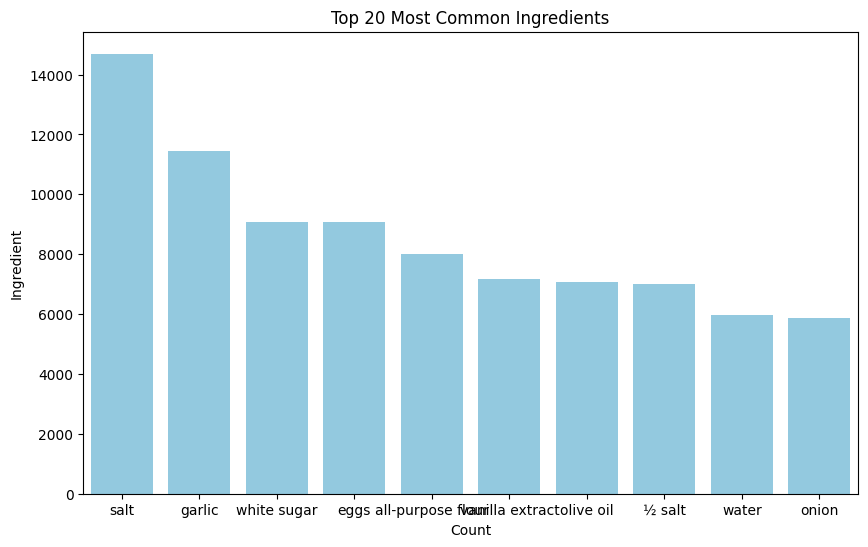

In [18]:
top_n = 20
plt.figure(figsize=(10,6))
sns.barplot(x='ingredient', y='count', data=ingredient_df.head(10), color='skyblue')
plt.title(f"Top {top_n} Most Common Ingredients")
plt.xlabel("Count")
plt.ylabel("Ingredient")
plt.show()

Most Common Ingredients (Word Cloud)¶
The word cloud provides a more visual representation of ingredient frequency.
Larger words indicate ingredients that appear more often across recipes, giving us an intuitive sense of what’s most common in cooking.

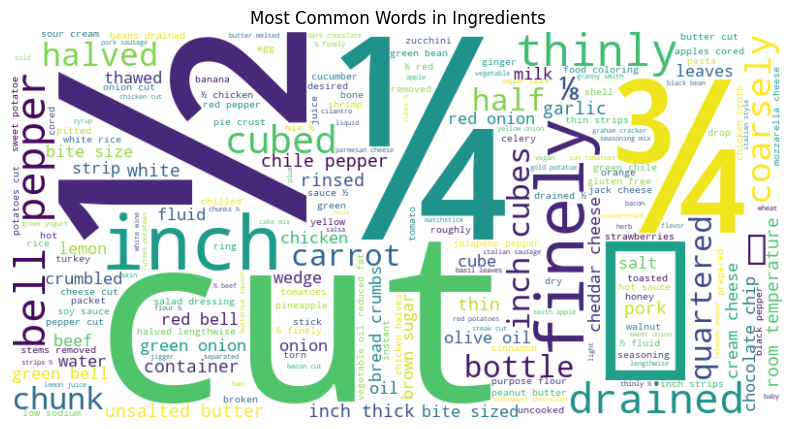

In [19]:
# Join all cleaned ingredients into one string
text = " ".join([ingredient for ingredient in ingredient_counts.keys()])

wc = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Ingredients')
plt.show()

Final Visualization¶
Final Visualization Dashboard
To conclude the EDA, we summarize the most important insights in one compact dashboard:

Distribution of Ingredients per Recipe → Most recipes use 5–13 ingredients.
Distribution of Steps per Recipe → Majority have 4–9 steps, with a few long recipes.
Top Categories → "Main Dishes", "Healthy Recipes", and "Appetizers and Snacks" dominate.
Most Common Ingredients → Salt, butter, sugar, and flour appear the most frequently.
This provides a quick overview for anyone exploring the dataset without scrolling through multiple plots.

In [20]:

fig1 = px.histogram(
    df, 
    x="num_ingredients", 
    nbins=30, 
    title="Distribution of Number of Ingredients",
    color_discrete_sequence=["skyblue"]
)

# --- 2. Histogram: Number of Steps ---
fig2 = px.histogram(
    df, 
    x="num_steps", 
    nbins=30, 
    title="Distribution of Number of Steps",
    color_discrete_sequence=["lightgreen"]
)

# --- 3. Top 15 Categories (Bar) ---
fig3 = px.bar(
    category_counts.head(15).reset_index(),
    x="count", y="category",
    orientation="h",
    title="Top 15 Recipe Categories",
    color="count",
    color_continuous_scale="Viridis"
)

# --- 4. Top 20 Ingredients (Bar) ---
fig4 = px.bar(
    ingredient_df.head(20),
    x="count", y="ingredient",
    orientation="h",
    title="Top 20 Most Common Ingredients",
    color="count",
    color_continuous_scale="Magma"
)

# Display all in a 2x2 grid
dashboard = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Ingredients Distribution", "Steps Distribution", "Top Categories", "Top Ingredients"),
    horizontal_spacing=0.15, vertical_spacing=0.15
)

# Add each figure as trace
for trace in fig1['data']:
    dashboard.add_trace(trace, row=1, col=1)

for trace in fig2['data']:
    dashboard.add_trace(trace, row=1, col=2)

for trace in fig3['data']:
    dashboard.add_trace(trace, row=2, col=1)

for trace in fig4['data']:
    dashboard.add_trace(trace, row=2, col=2)

dashboard.update_layout(
    title_text="Recipe Dataset Dashboard (Summary)",
    showlegend=False,
    height=900, width=1100
)

dashboard.show()


Summary & Key Insights¶
After exploring the recipe dataset, here are the main takeaways:

Recipe Categories

Main Dishes dominate the dataset (~3.3k recipes), followed by Healthy Recipes and Appetizers & Snacks.
Dessert-related categories (Cakes, Cookies, Pies) also appear in the top ranks, reflecting their popularity.
Ingredients & Steps

On average, recipes use 9 ingredients and have 5 steps.
Most recipes fall in a moderate range (5–13 ingredients, 4–9 steps).
Some recipes are outliers, requiring up to 35 ingredients or 25 steps, showing a small but significant group of complex dishes.
Common Ingredients

Everyday essentials like salt, butter, sugar, flour, olive oil, and eggs are the most frequently used.
Meat staples such as chicken, beef, and pork also feature prominently.
The word cloud confirms the dominance of these core ingredients across diverse cuisines.
Overall Pattern

The dataset reflects home-style cooking trends: moderate complexity, reliance on common pantry items, and strong representation of popular categories (main dishes, snacks, desserts).
This dataset provides rich opportunities for recipe recommendation systems.